In [1]:
%pip install -q -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import torch
import os
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.nn.utils as utils
import torch.optim as optim
from torchvision.models import densenet121, DenseNet121_Weights
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve
import pandas as pd
import numpy as np
from xray_dataset import XRayDataset
from transforms import equalize
import matplotlib.pyplot as plt

# Set up the device
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print("Using device:", device)

Using device: mps


## Import Data

In [2]:
# make sure data is in root directory
data_dir = '/Users/sree/nih-chest-xray-dataset/'
bad_labels = pd.read_csv(data_dir + 'cxr14_bad_labels.csv')
bad_labels = bad_labels.loc[:, ~bad_labels.columns.str.contains('^Unnamed')]
all_df = pd.read_csv(data_dir + 'train_df.csv')
all_df = all_df.drop(columns=['Patient ID'])
all_df = all_df.dropna()

LABELS = all_df.columns.tolist()[1:-1]
print("Labels:", LABELS)
print()

print('bad_labels:')
display(bad_labels.head())
print()

print('all_df:')
display(all_df.head())

img_dict = {}
for root, _, files in os.walk(data_dir):
    for file_name in files:
        if file_name.endswith(".png"):
            full_path = os.path.join(root, file_name)
            img_dict[file_name] = [full_path]

for index, row in all_df.iterrows():
    img_dict[row[0]].append(np.array(row[1:-1], dtype=int))

# List all files in the data directory
print(f'Total image files found : {len(img_dict.keys())}')

Labels: ['Cardiomegaly', 'Emphysema', 'Effusion', 'No Finding', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Atelectasis', 'Pneumothorax', 'Pleural_Thickening', 'Pneumonia', 'Fibrosis', 'Edema', 'Consolidation']

bad_labels:


,Index,Inverted,Not frontal,Rotated
0,00000583_024.png,1.0,0.0,0.0
1,00002180_000.png,1.0,0.0,0.0
2,00002300_026.png,1.0,0.0,0.0
3,00002371_015.png,1.0,0.0,0.0
4,00006209_001.png,1.0,0.0,0.0



all_df:


,Image Index,Cardiomegaly,Emphysema,Effusion,No Finding,Hernia,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Pleural_Thickening,Pneumonia,Fibrosis,Edema,Consolidation,FilePath
0,00000001_000.png,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,../input/data/images_001/images/00000001_000.png
1,00000001_001.png,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,../input/data/images_001/images/00000001_001.png
2,00000001_002.png,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,../input/data/images_001/images/00000001_002.png
3,00000002_000.png,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,../input/data/images_001/images/00000002_000.png
4,00000003_000.png,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,../input/data/images_001/images/00000003_000.png


/var/folders/_2/8p_kmtx12_l4hhv4d81frcf80000gn/T/ipykernel_42194/3611496235.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  img_dict[row[0]].append(np.array(row[1:-1], dtype=int))


Total image files found : 112120


In [3]:
print('img_dict length before dropping bad labels: ', len(img_dict.keys()))
print('total number of bad_labels: ', bad_labels.shape)

# Remove images from img_dict that exist in bad_labels
for bad_image in bad_labels['Index']:
    if bad_image in img_dict:
        del img_dict[bad_image]

print('img_dict length after dropping bad labels: ', len(img_dict.keys()))

img_dict length before dropping bad labels:  112120
total number of bad_labels:  (432, 4)
img_dict length after dropping bad labels:  111863


In [ ]:
# example of data in img_dict
img_dict['00000001_000.png']

['/Users/sree/nih-chest-xray-dataset/images_001/images/00000001_000.png',
 array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])]

In [ ]:
# Split the data into 80% train and 20% test
train_img_paths_and_labels, test_img_paths_and_labels = train_test_split(list(img_dict.values()), test_size=0.3, random_state=42)

# split into validation and test
test_img_paths_and_labels, val_img_paths_and_labels = train_test_split(test_img_paths_and_labels, test_size=0.5, random_state=42)

#  Define a transformation to convert images to tensors
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(10),    rotations not advised for x-ray images
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)), # reduced translation range
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 2))], p=0.5),  # Apply Gaussian blur with 50% probability
    transforms.Lambda(equalize),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create a dataset class for the XRay images
train_dataset = XRayDataset(train_img_paths_and_labels, transform=train_transform)
val_dataset = XRayDataset(val_img_paths_and_labels, transform=test_transform)
test_dataset = XRayDataset(test_img_paths_and_labels, transform=test_transform)

# Create a DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True, drop_last=True)

In [17]:
# check if the data is loaded correctly
data_iter = iter(train_loader)
images, labels = next(data_iter)
print(images.shape, len(labels))

torch.Size([64, 3, 224, 224]) 64


tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


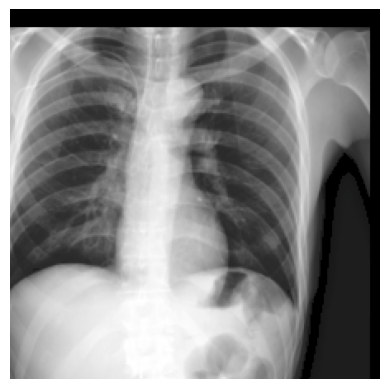

In [ ]:
# print a sample image
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

# Display the image
imshow(images[0], normalize=True)
print(labels[0])

In [ ]:
# compute class weights
class_weights = all_df[LABELS].sum(axis=0)
class_weights = class_weights.sum() / class_weights
class_weights = class_weights.to_numpy()
class_weights = torch.tensor(class_weights, device=device, dtype=torch.float32)
print('Class weights:', class_weights)

# normalize the class weights
norm_class_weights = class_weights / (class_weights.sum() * len(class_weights))
print('Normalized class weights:', norm_class_weights)

Class weights: tensor([ 50.8944,  56.2453,  10.6293,   2.3464, 622.1674,   7.1082,  24.4685,
         22.3539,  12.2353,  26.6828,  41.7970,  98.8327,  83.9168,  61.5122,
         30.3073], device='mps:0')
Normalized class weights: tensor([0.6630, 0.7327, 0.1385, 0.0306, 8.1047, 0.0926, 0.3187, 0.2912, 0.1594,
        0.3476, 0.5445, 1.2874, 1.0931, 0.8013, 0.3948], device='mps:0')


In [ ]:
# Custom Focal Loss (with class weights)
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, class_weights=None, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.class_weights = class_weights
        self.reduction = reduction
        
    def forward(self, inputs, targets):
        inputs = inputs.float()
        targets = targets.float()
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        probs = torch.sigmoid(inputs)
        p_t = torch.where(targets == 1, probs, 1 - probs)
        focal_factor = (1 - p_t) ** self.gamma
        loss = self.alpha * focal_factor * BCE_loss
        
        if self.class_weights is not None:
            class_weights = self.class_weights.unsqueeze(0).expand_as(targets)
            loss = loss * class_weights

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss

In [ ]:
# class for the model
class XRayModel(nn.Module):
    def __init__(self, num_classes):
        super(XRayModel, self).__init__()
        self.densenet = densenet121(weights=DenseNet121_Weights.IMAGENET1K_V1)
        num_feats = self.densenet.classifier.in_features
        self.densenet.classifier = nn.Sequential(
            nn.Linear(num_feats, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
       
    def forward(self, x):
        x = self.densenet(x)
        return x

In [24]:
# Define the model, optimizer, and loss function
model = XRayModel(num_classes=len(LABELS))
model.to(device)
lr = 1e-4
weight_decay = 1e-5
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
criterion = FocalLoss(alpha=0.25, gamma=2.0, class_weights=norm_class_weights)
num_epochs = 2
max_grad_norm = 1.0

# Early stopping parameters
patience = 5
best_val_loss = float('inf')
epochs_no_improve = 0
early_stop = False
min_delta = 0.0001

In [25]:
# mixup augmentation
def mixup_data(x, y, alpha=0.2):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [26]:
# Training loop
for epoch in range(num_epochs):
    if early_stop:
        print("Early stopping")
        break

    model.train()
    running_loss = 0.0
    i = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Mixup augmentation
        if np.random.rand() < 0.8: # 80% probability of applying mixup
            images, labels_a, labels_b, lam = mixup_data(images, labels, alpha=0.2)
            mixup = True
        else:
            mixup = False

        optimizer.zero_grad()
        outputs = model(images)
        loss = mixup_criterion(criterion, outputs, labels_a, labels_b, lam) if mixup else criterion(outputs, labels)
        loss.backward()

        # Gradient clipping
        utils.clip_grad_norm_(model.parameters(), max_grad_norm)

        optimizer.step()
        
        running_loss += loss.item()

        print(f'Batch [{i+1}/{len(train_loader)}], Loss: {loss.item()}')
        i += 1
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}')

    # Validation loop
    model.eval()
    val_running_loss = 0.0
    i = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()

            print(f'Validation Batch [{i+1}/{len(val_loader)}], Loss: {loss.item()}')
            i += 1

    val_loss = val_running_loss / len(val_loader)
    print(f'Validation Loss: {val_loss}')

    # Adjust learning rate based on validation loss
    scheduler.step(val_loss)

    # Check early stopping
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'checkpoint.pth')
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            early_stop = True

# Load the last checkpoint with the best model
model.load_state_dict(torch.load('checkpoint.pth'))

# Save the final model
torch.save(model.state_dict(), 'xray_model.pth')

Batch [1/1223], Loss: 0.04213135316967964
Batch [2/1223], Loss: 0.033767782151699066
Batch [3/1223], Loss: 0.028605390340089798
Batch [4/1223], Loss: 0.023893969133496284
Batch [5/1223], Loss: 0.020791590213775635
Batch [6/1223], Loss: 0.018154336139559746
Batch [7/1223], Loss: 0.01594509743154049
Batch [8/1223], Loss: 0.014159365557134151
Batch [9/1223], Loss: 0.01246308907866478
Batch [10/1223], Loss: 0.01090142410248518
Batch [11/1223], Loss: 0.009904978796839714
Batch [12/1223], Loss: 0.00871214922517538
Batch [13/1223], Loss: 0.00732130091637373
Batch [14/1223], Loss: 0.007277638651430607
Batch [15/1223], Loss: 0.0067273592576384544
Batch [16/1223], Loss: 0.005194576922804117
Batch [17/1223], Loss: 0.005567669868469238
Batch [18/1223], Loss: 0.006186649203300476
Batch [19/1223], Loss: 0.005792466923594475
Batch [20/1223], Loss: 0.00472365552559495
Batch [21/1223], Loss: 0.0068082138895988464
Batch [22/1223], Loss: 0.003799805184826255
Batch [23/1223], Loss: 0.002611399395391345
Ba

/var/folders/_2/8p_kmtx12_l4hhv4d81frcf80000gn/T/ipykernel_42194/3554017342.py:45: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision[label] * recall[label]) / (precision[label] + recall[label])
/var/folders/_2/8p_kmtx12_l4hhv4d81frcf80000gn/T/ipykernel_42194/3554017342.py:45: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision[label] * recall[label]) / (precision[label] + recall[label])
/var/folders/_2/8p_kmtx12_l4hhv4d81frcf80000gn/T/ipykernel_42194/3554017342.py:45: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision[label] * recall[label]) / (precision[label] + recall[label])
/var/folders/_2/8p_kmtx12_l4hhv4d81frcf80000gn/T/ipykernel_42194/3554017342.py:45: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision[label] * recall[label]) / (precision[label] + recall[label])
/var/folders/_2/8p_kmtx12_l4hhv4d81frcf80000gn/T/ipykernel_42194/3554017342.py:45: RuntimeWarning: i

Optimal Thresholds: {'Cardiomegaly': 0.45730394, 'Emphysema': 0.26981747, 'Effusion': 0.5022391, 'No Finding': 0.65793395, 'Hernia': 0.24422108, 'Infiltration': 0.5030659, 'Mass': 0.30839723, 'Nodule': 0.33093274, 'Atelectasis': 0.42044005, 'Pneumothorax': 0.32311326, 'Pleural_Thickening': 0.31381837, 'Pneumonia': 0.2802181, 'Fibrosis': 0.2726705, 'Edema': 0.38080096, 'Consolidation': 0.37076133}


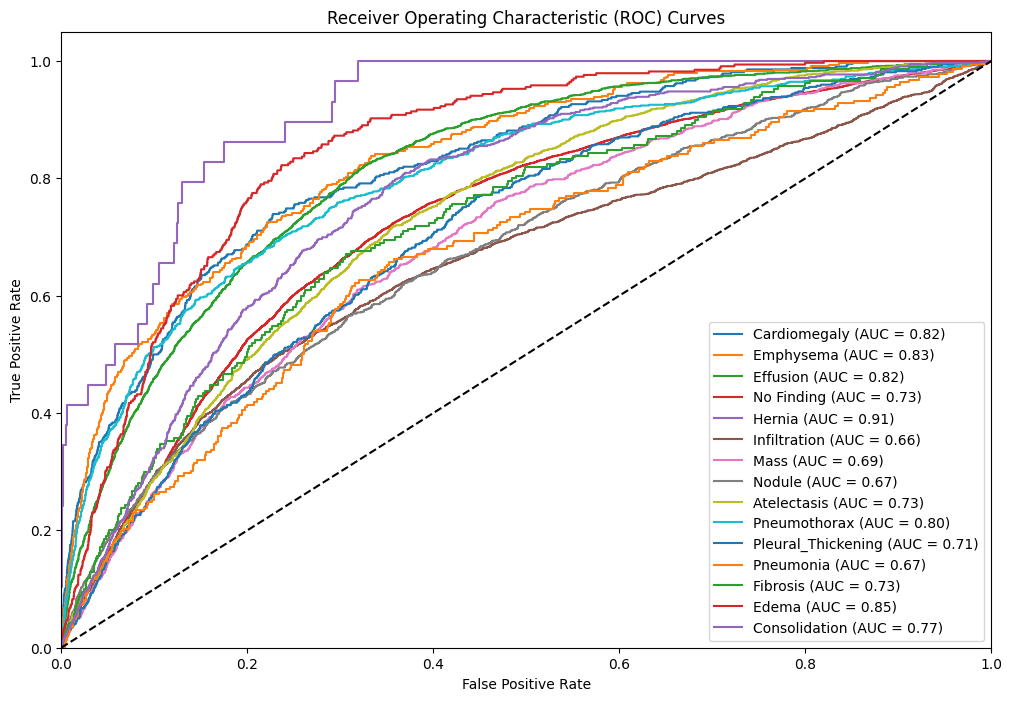

Classification Report:
{'Cardiomegaly': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 422.0}, 'Emphysema': {'precision': 0.18604651162790697, 'recall': 0.32941176470588235, 'f1-score': 0.23779193205944799, 'support': 340.0}, 'Effusion': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1982.0}, 'No Finding': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 9088.0}, 'Hernia': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 29.0}, 'Infiltration': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 2954.0}, 'Mass': {'precision': 0.11436070491188602, 'recall': 0.3724053724053724, 'f1-score': 0.17498565691336776, 'support': 819.0}, 'Nodule': {'precision': 0.15472312703583063, 'recall': 0.29081632653061223, 'f1-score': 0.20198440822111977, 'support': 980.0}, 'Atelectasis': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1708.0}, 'Pneumothorax': {'precision': 0.2807731434384537, 'recall': 0.3484848484848485, 'f1-sc

/Users/sree/anaconda3/envs/ds/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sree/anaconda3/envs/ds/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Load the model
model.load_state_dict(torch.load('xray_model.pth', map_location=device))

# Validation loop
model.eval()
all_labels = []
all_probabilities = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        probabilities = torch.sigmoid(outputs)

        all_labels.append(labels.cpu().numpy())
        all_probabilities.append(probabilities.cpu().numpy())


# Concatenate all batches
all_labels = np.concatenate(all_labels, axis=0)
all_probabilities = np.concatenate(all_probabilities, axis=0)

# precision-recall curve for determining thresholds
precision = {}
recall = {}
thresholds = {}
optimal_thresholds = {}

for i, label in enumerate(LABELS):
    precision[label], recall[label], thresholds[label] = precision_recall_curve(all_labels[:, i], all_probabilities[:, i])
    f1_scores = 2 * (precision[label] * recall[label]) / (precision[label] + recall[label])
    optimal_thresholds[label] = thresholds[label][np.argmax(f1_scores)]

print("Optimal Thresholds:", optimal_thresholds)

# Get predictions from probabilities based on different thresholds for each class
all_predictions = np.zeros_like(all_probabilities)
for i, label in enumerate(LABELS):
    all_predictions[:, i] = (all_probabilities[:, i] > optimal_thresholds[label]).astype(int)

# Calculate ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i, label in enumerate(LABELS):
    fpr[label], tpr[label], _ = roc_curve(all_labels[:, i], all_probabilities[:, i])
    roc_auc[label] = roc_auc_score(all_labels[:, i], all_probabilities[:, i])

# Plot ROC curves
plt.figure(figsize=(12, 8))
for label in LABELS:
    plt.plot(fpr[label], tpr[label], label=f'{label} (AUC = {roc_auc[label]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')
plt.show()

In [28]:
from torch.utils.tensorboard import SummaryWriter

def create_tensorboard_visualization(model_path, data_loader, device):
    # Load the model
    model = XRayModel(num_classes=len(LABELS))
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()

    # Create a SummaryWriter
    writer = SummaryWriter(log_dir='logs/tensorboard')

    # Extract embeddings and labels
    embeddings = []
    labels_list = []
    with torch.no_grad():
        i = 0
        for images, labels in data_loader:
            print('iter:', i)
            images = images.to(device)
            labels = labels.to(device)
            
            # Get the embeddings from the layer before the output layer
            features = model.densenet.features(images)
            embeddings.append(features.cpu())
            labels_list.append(labels.cpu())
            i += 1

    # Concatenate all embeddings and labels
    embeddings = torch.cat(embeddings, dim=0)
    labels_list = torch.cat(labels_list, dim=0)

    # Add embeddings to TensorBoard
    writer.add_embedding(embeddings, metadata=labels_list, label_img=images.cpu())

    # Close the writer
    writer.close()

In [ ]:
create_tensorboard_visualization("xray_model.pth", test_loader, device)

iter: 0
iter: 1
iter: 2
iter: 3
iter: 4
iter: 5
iter: 6
iter: 7
iter: 8
iter: 9
iter: 10
iter: 11
iter: 12
iter: 13
iter: 14
iter: 15
iter: 16
iter: 17
iter: 18
iter: 19
iter: 20
iter: 21
iter: 22
iter: 23
iter: 24
iter: 25
iter: 26
iter: 27
iter: 28
iter: 29
iter: 30
iter: 31
iter: 32
iter: 33
iter: 34
iter: 35
iter: 36
iter: 37
iter: 38
iter: 39
iter: 40
iter: 41
iter: 42
iter: 43
iter: 44
iter: 45
iter: 46
iter: 47
iter: 48
iter: 49
iter: 50
iter: 51
iter: 52
iter: 53
iter: 54
iter: 55
iter: 56
iter: 57
iter: 58
iter: 59
iter: 60
iter: 61
iter: 62
iter: 63
iter: 64
iter: 65
iter: 66
iter: 67
iter: 68
iter: 69
iter: 70
iter: 71
iter: 72
iter: 73
iter: 74
iter: 75
iter: 76
iter: 77
iter: 78
iter: 79
iter: 80
iter: 81
iter: 82
iter: 83
iter: 84
iter: 85
iter: 86
iter: 87
iter: 88
iter: 89
iter: 90
iter: 91
iter: 92
iter: 93
iter: 94
iter: 95
iter: 96
iter: 97
iter: 98
iter: 99
iter: 100
iter: 101
iter: 102
iter: 103
iter: 104
iter: 105
iter: 106
iter: 107
iter: 108
iter: 109
iter: 110


AssertionError: #images should equal with #data points